In [ ]:
#Run once per session
!pip install fastai -q --upgrade

# Lesson 6: Keypoint Regression and Object Detection

* Keypoint or **Pose** detection:
* `n` keypoints are found using a CNN where `n` = max number of keypoints present

## Libraries

In [ ]:
from fastai.vision.all import *

## Cleaning Some Data:

For our dataset, we will be working from the Kaggle [Cats](https://www.kaggle.com/crawford/cat-dataset) dataset. Now we are purposefully going to go about cleaning our data beforehand so we understand what it is like

In [ ]:
url = "https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM"

In [ ]:
!gdown {url}

Downloading...
From: https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM
To: /content/cat-dataset.zip
4.33GB [01:19, 54.2MB/s]


Now that it's downloaded, let's unzip it using `ZipFile`

In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('cat-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall()

How is the data stored? Let's talk a look by walking on our folders:

In [ ]:
import os

In [ ]:
[x[0] for x in os.walk('cats')]

['cats',
 'cats/CAT_05',
 'cats/CAT_06',
 'cats/CAT_02',
 'cats/CAT_01',
 'cats/CAT_03',
 'cats/CAT_04',
 'cats/CAT_00']

We have some duplicate folders, let's get rid of the `CAT_` directory and just work out of the `cats` folder

In [ ]:
for i in range(7):
  path = Path(f'CAT_0{i}')
  shutil.rmtree(path)

Now we need to move all the files up one level. We can use `pathlib`

In [ ]:
for i in range(7):
  paths = Path(f'cats/CAT_0{i}').ls()
  for path in paths:
    p = Path(path).absolute()
    par = p.parents[1]
    p.rename(par/p.name)

How is our data labeled? Our keypoints are available via an image's corresponding `.cat` file. Let's make sure we have an equal number of labels to images

In [ ]:
path = Path('cats')

In [ ]:
lbls = get_files(path, extensions='.cat')
imgs = get_image_files(path)

In [ ]:
test_eq(len(lbls), len(imgs))

We're good to go! - *Or are we*

## Visualizing our data

Let's first grab a label based on a file name

In [ ]:
def img2kpts(f): return f'{str(f)}.cat'

Let's try this out on an image

In [ ]:
fname = imgs[0]

In [ ]:
img = PILImage.create(fname)

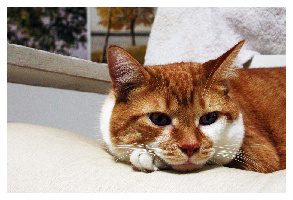

In [ ]:
img.show()

Now let's grab some coordinates!

In [ ]:
kpts = np.genfromtxt(img2kpts(fname)); kpts

array([  9., 563., 411., 736., 404., 669., 545., 404., 340., 380., 148.,
       528., 261., 739., 254., 869., 123., 811., 325.])

Wait, that's not our keypoints. What is this?

It is, go back to the Kaggle and they describe how it is done. The number of points by default are 9 (the first value in our list):
* Left eye
* Right eye
* Mouth
* Left ear 1
* Left ear 2
* Left ear 3
* Right ear 1
* Right ear 2
* Right ear 3

Now we need to seperate our keypoints into pairs and a `tensor`

In [ ]:
def sep_points(coords:array):
  "Seperate a set of points to groups"
  kpts = []
  for i in range(1, int(coords[0]*2), 2):
    kpts.append([coords[i], coords[i+1]])
  return tensor(kpts)

In [ ]:
pnts = sep_points(kpts); pnts

tensor([[563., 411.],
        [736., 404.],
        [669., 545.],
        [404., 340.],
        [380., 148.],
        [528., 261.],
        [739., 254.],
        [869., 123.],
        [811., 325.]])

Now let's put it all together. We need to return some `TensorPoints` to have it work in `fastai`

First let's take what we did above and make a `get_y` function

In [ ]:
def get_y(f:Path):
  "Get keypoints for `f` image"
  pts = np.genfromtxt(img2kpts(f))
  return sep_points(pts)

Now there is one more bit of cleaning we need to do, and that is to make sure all my points are within the bounds of my image. But how do I do this? Let's write a list of `bad_fnames` in which we run the following test:
1. Open an image and the points
2. If any point is outside the image, remove the file
3. If any point is negative, remove the file

In [ ]:
bad_imgs = []

In [ ]:
for name in imgs:
  im = PILImage.create(name)
  y = get_y(name)
  for x in y:
    if x[0] < im.size[0]:
      if x[0] < 0:
        bad_imgs.append(name)
      if x[1] < im.size[1]:
        if x[1] < 0:
          bad_imgs.append(name)
      else:
        bad_imgs.append(name)
    else:
      bad_imgs.append(name)

Let's take a look at how many bad images we had!

In [ ]:
len(bad_imgs)

1430

That's a lot! But couldn't we also get repeats from the above code? Let's check for that

In [ ]:
len(set(bad_imgs))

1062

We could. So in total we have 1,062 images who's points go out of bounds. There's a few different ways we can deal with this.

1. Remove said image
2. Zero those points to (-1,-1) (through a transform
3. Keep the points

Each have their benefits. We'll do #1

In [ ]:
for name in list(set(bad_imgs)):
  name.unlink()

Now that we've removed all the bad images, let's continue

In [ ]:
imgs = get_image_files(path)
fname = imgs[0]
img = PILImage.create(fname)

Now let's get our `TensorPoints`, just to show an example

In [ ]:
def get_ip(img:PILImage, pts:array): return TensorPoint(pts, sz=img.size)

In [ ]:
ip = get_y(fname); ip

tensor([[563., 411.],
        [736., 404.],
        [669., 545.],
        [404., 340.],
        [380., 148.],
        [528., 261.],
        [739., 254.],
        [869., 123.],
        [811., 325.]])

In [ ]:
tp = get_ip(img, ip)

Now we can visualize our points. We can pass in an axis to overlay them on top of our image

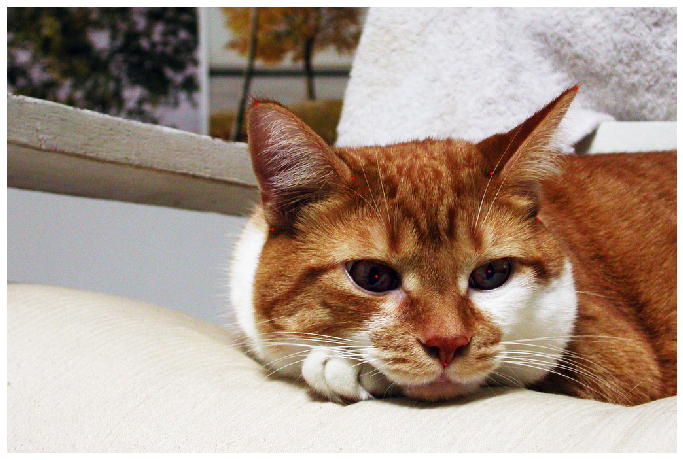

In [ ]:
ax = img.show(figsize=(12,12))
tp.show(ctx=ax)

Great, let's datablock it now. We'll keep the transforms very simple for our example problem to just a `Resize`

# DataBlock and Train

We'll also talk about the "Clamping" option. This can be useful for more than our ground truth. Consider this case:

* RandomResizeCrop crops our image and makes the point go off-screen. Do we keep the point and let the model guess, or adjust that point?

Let's build transform to adjust for this (our dataset will not use this but this is for an example) as we will use either **padding** or **squishing** on our resize

In [ ]:
class ClampBatch(Transform):
  "Clamp points to a minimum and maximum in a batch"
  order = 4
  def __init__(self, min=-1, max=1, **kwargs):
    super().__init__(**kwargs)
    self.min, self.max = min, max
  def encodes(self, x:(TensorPoint)):
    for i, sets in enumerate(x):
      for j, pair in enumerate(sets):
        cpnt = torch.clamp(pair, self.min, self.max)
        if any(cpnt>=1) or any(cpnt<=-1):
          x[i][j] = tensor([-1,-1])
    return x

We'll go ahead and run `ClampBatch` here though just in case something happens during one of our transforms (though most likely not)

In [ ]:
item_tfms = [Resize(448, method='squish')]
batch_tfms = [Flip(), Rotate(), Zoom(), Warp(), ClampBatch()]

All Keypoint agumentation available:
* Rotate, FlipItem, DihedralItem
* CropPad, RandomCrop, Resize, RandomResizeCrop
* Zoom, Warp

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

In [ ]:
bs=24

With how our `get_y` is, we will want a base path of ''. Let's look at a `dblock.summary()` output now to see what's going on in our `Pipeline`

In [ ]:
dblock.summary('')

Setting-up type transforms pipelines
Found 8931 items
2 datasets of sizes 7145,1786
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> TensorPoint.create

Building one sample
  Pipeline: PILBase.create
    starting from
      cats/00000311_008.jpg
    applying PILBase.create gives
      <fastai.vision.core.PILImage image mode=RGB size=500x368 at 0x7FF19F6D79E8>
  Pipeline: get_y -> TensorPoint.create
    starting from
      cats/00000311_008.jpg
    applying get_y gives
      Tensor of size 9x2
    applying TensorPoint.create gives
      TensorPoint of size 9x2

Final sample: (<fastai.vision.core.PILImage image mode=RGB size=500x368 at 0x7FF19F63B630>, TensorPoint([[241., 169.],
        [319., 165.],
        [283., 226.],
        [187., 147.],
        [179.,  57.],
        [235., 106.],
        [308., 101.],
        [357.,  41.],
        [364., 139.]]))


Setting up after_item: Pipeline: PointScaler -> Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up aft

This is cool! It shows us exactly what is happenning when, and if a transform doesn't work we can go through and adjust and debug through it! Since it was successfull in building a batch, let's build our `DataBunch`

In [ ]:
dls = dblock.dataloaders('', path='', bs=bs)

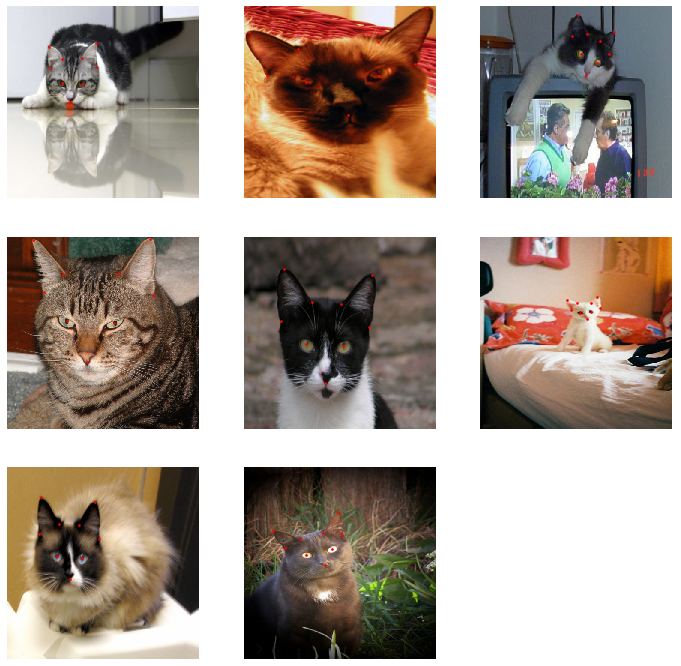

In [ ]:
dls.show_batch(max_n=8, figsize=(12,12))

Great, now let's give it a `.c` attribute so we can create our model's output easier

In [ ]:
dls.c = dls.train.after_item.c

In [ ]:
dls.c

18

Now let's go through and generate a custom model and head for regression, but how do we do this?

If we know our outputs and inputs, we can make use of two functions, `create_body`, and `create_head`. `create_body` will chop the top of our pre-trained model for us, and `create_head` will make a special `fastai` configured head that has shown to work better. What will we need?

* Outputs: 18 (9 pairs of points)
* Inputs: 1024 filter (2x the last ResNet18 layer)

In [ ]:
body = create_body(resnet18, pretrained=True)

In [ ]:
body[-1][-1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Now let's make our head

In [ ]:
head = create_head(nf=1024, n_out=18); head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=18, bias=False)
)

Finally, we'll wrap them together

In [ ]:
arch = nn.Sequential(body, head)

Now we want to utilize transfer learning as best as we can, so we need those discrimitive learning rates. How do we do this? We need to define what this should look like. Here is what it is for our resnet (this is to your discretion based on what you find)

In [ ]:
def _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)

In [ ]:
arch[1:]

Sequential(
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): full: False
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=18, bias=False)
  )
)

We can see that the `[1:]` grabs the head of our model, and we can safely freeze the body

Lastly we want to initialize our model

In [ ]:
apply_init(arch[1], nn.init.kaiming_normal_)

For our loss funciton, we will use `MSELossFlat`

Now that we have all the pieces, let's make a model!

In [ ]:
learn = Learner(dls, arch, loss_func=MSELossFlat(), splitter = _resnet_split,
                opt_func=ranger)

In [ ]:
learn.freeze()

And let's fit!

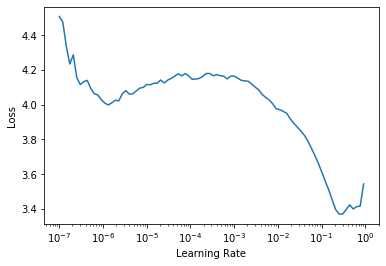

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.155805,0.079843,02:02
1,0.121360,0.075804,02:02
2,0.057329,0.031406,02:02
3,0.029215,0.014585,02:01
4,0.017399,0.010925,02:04


Let's look at some of the initial results

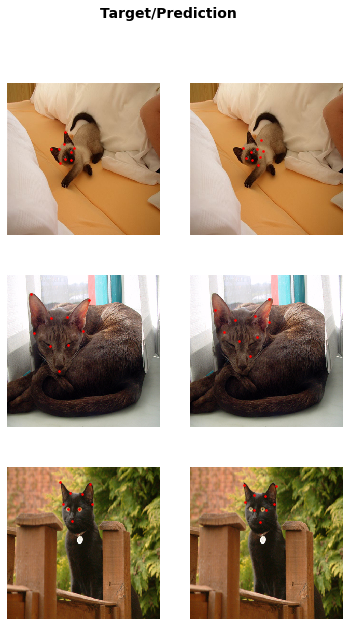

In [ ]:
learn.show_results()

Alright, we're getting there! Let's unfreeze and find a new learning rate

In [ ]:
learn.unfreeze()

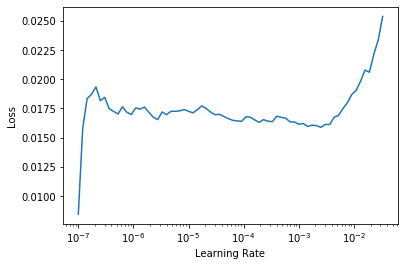

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(5, 1e-4)

epoch,train_loss,valid_loss,time
0,0.013294,0.008114,02:07
1,0.012472,0.006793,02:06
2,0.010956,0.006156,02:07
3,0.010989,0.005755,02:06
4,0.009330,0.005135,02:06


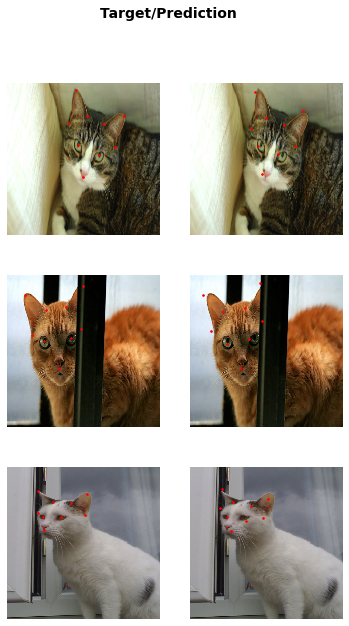

In [ ]:
learn.show_results()

Looks much better! And in only ten epochs! (most anything I've seen with this sort of problem in `PyTorch` fits for 100+ epochs)